In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # authorizes Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, pathlib

# CHANGE THIS to where you want to work in Drive:
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/HPC_FDTD_grock"

pathlib.Path(PROJECT_DIR).mkdir(parents=True, exist_ok=True)

# Make it the working directory for both Python and bash cells
os.chdir(PROJECT_DIR)
print("Now in:", os.getcwd())


Now in: /content/drive/MyDrive/Colab Notebooks/HPC_FDTD_grock


# **Stage 1** – Cell 1: Install NVIDIA HPC SDK (Required for OpenACC Compilation)

In [ ]:
%%shell
# wget https://developer.download.nvidia.com/hpc-sdk/25.7/nvhpc_2025_257_Linux_x86_64_cuda_12.9.tar.gz
tar xpzf nvhpc_2025_257_Linux_x86_64_cuda_12.9.tar.gz
export NVHPC_SILENT=true
export NVHPC_INSTALL_DIR=/opt/nvidia/hpc_sdk
export NVHPC_INSTALL_TYPE=single
cd nvhpc_2025_257_Linux_x86_64_cuda_12.9 && ./install
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH
nvc++ --version  # Verify installation

./install: line 15: test: /content/drive/MyDrive/Colab: binary operator expected
/content/drive/MyDrive/Colab Notebooks/HPC_FDTD_grock/nvhpc_2025_257_Linux_x86_64_cuda_12.9/install_components does not exist, aborting...
/bin/bash: line 8: nvc++: command not found


CalledProcessError: Command '# wget https://developer.download.nvidia.com/hpc-sdk/25.7/nvhpc_2025_257_Linux_x86_64_cuda_12.9.tar.gz
tar xpzf nvhpc_2025_257_Linux_x86_64_cuda_12.9.tar.gz
export NVHPC_SILENT=true
export NVHPC_INSTALL_DIR=/opt/nvidia/hpc_sdk
export NVHPC_INSTALL_TYPE=single
cd nvhpc_2025_257_Linux_x86_64_cuda_12.9 && ./install
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH
nvc++ --version  # Verify installation
' returned non-zero exit status 127.

# **Stage 1** – Cell 2: Write the Complete OpenACC Code to a File

In [ ]:
%%writefile fdtd_openacc.cpp
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <sys/time.h>
#include <openacc.h>

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

extern "C" int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers);

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers) {
  acc_init(acc_device_nvidia);
  if (deviceid != -1) {
    acc_set_device_num(deviceid, acc_device_nvidia);
  }
  float (*__restrict m)[m_vec->size[1]][m_vec->size[2]] __attribute__((aligned(64))) = (float (*)[m_vec->size[1]][m_vec->size[2]]) m_vec->data;
  float (*__restrict src)[src_vec->size[1]] __attribute__((aligned(64))) = (float (*)[src_vec->size[1]]) src_vec->data;
  float (*__restrict src_coords)[src_coords_vec->size[1]] __attribute__((aligned(64))) = (float (*)[src_coords_vec->size[1]]) src_coords_vec->data;
  float (*__restrict u)[u_vec->size[1]][u_vec->size[2]][u_vec->size[3]] __attribute__((aligned(64))) = (float (*)[u_vec->size[1]][u_vec->size[2]][u_vec->size[3]]) u_vec->data;
#pragma acc enter data copyin(u[0:u_vec->size[0]][0:u_vec->size[1]][0:u_vec->size[2]][0:u_vec->size[3]])
#pragma acc enter data copyin(m[0:m_vec->size[0]][0:m_vec->size[1]][0:m_vec->size[2]])
#pragma acc enter data copyin(src[0:src_vec->size[0]][0:src_vec->size[1]])
#pragma acc enter data copyin(src_coords[0:src_coords_vec->size[0]][0:src_coords_vec->size[1]])
  float r1 = 1.0F / (dt * dt);
  float r2 = 1.0F / (h_x * h_x);
  float r3 = 1.0F / (h_y * h_y);
  float r4 = 1.0F / (h_z * h_z);
  for (int time = time_m, t0 = (time) % (3), t1 = (time + 2) % (3), t2 = (time + 1) % (3); time <= time_M; time += 1, t0 = (time) % (3), t1 = (time + 2) % (3), t2 = (time + 1) % (3)) {
    START(section0)
#pragma acc parallel loop collapse(3) present(m, u)
    for (int x = x_m; x <= x_M; x += 1) {
      for (int y = y_m; y <= y_M; y += 1) {
        for (int z = z_m; z <= z_M; z += 1) {
          float r5 = -2.50F * u[t0][x + 4][y + 4][z + 4];
          u[t2][x + 4][y + 4][z + 4] = dt * dt * (r2 * (r5 + (-8.33333333e-2F) * (u[t0][x + 2][y + 4][z + 4] + u[t0][x + 6][y + 4][z + 4]) + 1.333333330F * (u[t0][x + 3][y + 4][z + 4] + u[t0][x + 5][y + 4][z + 4])) + r3 * (r5 + (-8.33333333e-2F) * (u[t0][x + 4][y + 2][z + 4] + u[t0][x + 4][y + 6][z + 4]) + 1.333333330F * (u[t0][x + 4][y + 3][z + 4] + u[t0][x + 4][y + 5][z + 4])) + r4 * (r5 + (-8.33333333e-2F) * (u[t0][x + 4][y + 4][z + 2] + u[t0][x + 4][y + 4][z + 6]) + 1.333333330F * (u[t0][x + 4][y + 4][z + 3] + u[t0][x + 4][y + 4][z + 5])) - (-2.0F * r1 * u[t0][x + 4][y + 4][z + 4] + r1 * u[t1][x + 4][y + 4][z + 4]) * m[x + 4][y + 4][z + 4]) / m[x + 4][y + 4][z + 4];
        }
      }
    }
    STOP(section0, timers)
    START(section1)
    if (src_vec->size[0] * src_vec->size[1] > 0 && p_src_M - p_src_m + 1 > 0) {
#pragma acc parallel loop collapse(4) present(m, src, src_coords, u)
      for (int p_src = p_src_m; p_src <= p_src_M; p_src += 1) {
        for (int rsrcx = 0; rsrcx <= 1; rsrcx += 1) {
          for (int rsrcy = 0; rsrcy <= 1; rsrcy += 1) {
            for (int rsrcz = 0; rsrcz <= 1; rsrcz += 1) {
              int posx = static_cast<int>(std::floor((-o_x + src_coords[p_src][0]) / h_x));
              int posy = static_cast<int>(std::floor((-o_y + src_coords[p_src][1]) / h_y));
              int posz = static_cast<int>(std::floor((-o_z + src_coords[p_src][2]) / h_z));
              float px = -std::floor((-o_x + src_coords[p_src][0]) / h_x) + (-o_x + src_coords[p_src][0]) / h_x;
              float py = -std::floor((-o_y + src_coords[p_src][1]) / h_y) + (-o_y + src_coords[p_src][1]) / h_y;
              float pz = -std::floor((-o_z + src_coords[p_src][2]) / h_z) + (-o_z + src_coords[p_src][2]) / h_z;
              if (rsrcx + posx >= x_m - 1 && rsrcy + posy >= y_m - 1 && rsrcz + posz >= z_m - 1 && rsrcx + posx <= x_M + 1 && rsrcy + posy <= y_M + 1 && rsrcz + posz <= z_M + 1) {
                float r0 = 1.0e-2F * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time][p_src] / m[posx + 4][posy + 4][posz + 4];
#pragma acc atomic update
                u[t2][rsrcx + posx + 4][rsrcy + posy + 4][rsrcz + posz + 4] += r0;
              }
            }
          }
        }
      }
    }
    STOP(section1, timers)
  }
#pragma acc exit data copyout(u[0:u_vec->size[0]][0:u_vec->size[1]][0:u_vec->size[2]][0:u_vec->size[3]])
#pragma acc exit data delete(u[0:u_vec->size[0]][0:u_vec->size[1]][0:u_vec->size[2]][0:u_vec->size[3]]) if (devicerm)
#pragma acc exit data delete(m[0:m_vec->size[0]][0:m_vec->size[1]][0:m_vec->size[2]]) if (devicerm)
#pragma acc exit data delete(src[0:src_vec->size[0]][0:src_vec->size[1]]) if (devicerm)
#pragma acc exit data delete(src_coords[0:src_coords_vec->size[0]][0:src_coords_vec->size[1]]) if (devicerm)
  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 2) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> (e.g., 128 for 128^3 grid)" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);  // Grid size (n x n x n inner points)
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 100;  // 100 time steps for benchmarking
  int p_src_m = 0, p_src_M = 0;  // One source
  int deviceid = 0, devicerm = 1;

  // Allocate u (4D: time buffers x (nx+8) x (ny+8) x (nz+8))
  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  size_t u_bytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = aligned_alloc(64, u_bytes);
  std::memset(u_vec.data, 0, u_bytes);

  // Allocate m (3D: (nx+8) x (ny+8) x (nz+8))
  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  size_t m_bytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = aligned_alloc(64, m_bytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_bytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  // Allocate src (2D: (time_M+1) x (p_src_M+1))
  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M + 1};
  size_t src_bytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = aligned_alloc(64, src_bytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_bytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  // Allocate src_coords (2D: (p_src_M+1) x 3)
  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M + 1, 3};
  size_t src_coords_bytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = aligned_alloc(64, src_coords_bytes);
  float (*src_coords)[3] = (float (*)[3])src_coords_vec.data;
  src_coords[0][0] = (nx / 2) * h_x;  // Center source
  src_coords[0][1] = (ny / 2) * h_y;
  src_coords[0][2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  // Call kernel
  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers);

  // Output timings
  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  // Cleanup
  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Writing fdtd_openacc.cpp


# **Stage 1** – Cell 3: Compile the OpenACC Code

In [ ]:
%%shell
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH
nvc++ -acc -Minfo=accel -o fdtd_openacc fdtd_openacc.cpp

/bin/bash: line 2: nvc++: command not found


CalledProcessError: Command 'export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH
nvc++ -acc -Minfo=accel -o fdtd_openacc fdtd_openacc.cpp
' returned non-zero exit status 127.

# **Stage 1** – Cell 4: Run Experiments and Benchmark (Time and Memory)

In [ ]:
%%shell
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH

sizes=(64 128 256)
times=()
mems=()

for size in "${sizes[@]}"; do
  echo "Running for grid size $size^3"
  nvidia-smi  # Before run
  ./fdtd_openacc $size > output_$size.txt
  peak_mem=$(nvidia-smi | grep MiB | awk '{print $9}' | head -1 | sed 's/MiB//')
  nvidia-smi  # After run
  total_time=$(grep "Total Time" output_$size.txt | awk '{print $3}')
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times+=($total_time)
  mems+=($peak_mem)
done

# Output results for Python plotting
echo "Grid Sizes: ${sizes[@]}"
echo "Times: ${times[@]}"
echo "Memories: ${mems[@]}"

Running for grid size 64^3
Wed Sep 17 04:17:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   30C    P0             51W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------

In [ ]:
%%shell
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/25.7/compilers/bin:$PATH

sizes=(64 128 256 512 1024)
times=()
mems=()

for size in "${sizes[@]}"; do
  echo "Running for grid size $size^3"
  rm -f mem.log
  (while kill -0 $$ 2> /dev/null; do nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits >> mem.log; sleep 0.1; done) &
  monitor_pid=$!
  ./fdtd_openacc $size > output_$size.txt
  kill $monitor_pid > /dev/null 2>&1
  total_time=$(grep "Total Time" output_$size.txt | awk '{print $3}')
  peak_mem=$(sort -n mem.log | tail -1)
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times+=($total_time)
  mems+=($peak_mem)
done

echo "Grid Sizes: ${sizes[@]}"
echo "Times: ${times[@]}"
echo "Memories: ${mems[@]}"

Running for grid size 64^3
Peak GPU Memory: 0 MiB
Total Time: 0.004041 s
Running for grid size 128^3
Peak GPU Memory: 425 MiB
Total Time: 0.009449 s
Running for grid size 256^3
Peak GPU Memory: 711 MiB
Total Time: 0.051363 s
Running for grid size 512^3
Peak GPU Memory: 2575 MiB
Total Time: 0.342614 s
Running for grid size 1024^3
Peak GPU Memory: 17201 MiB
Total Time: 2.60647 s
Grid Sizes: 64 128 256 512 1024
Times: 0.004041 0.009449 0.051363 0.342614 2.60647
Memories: 0 425 711 2575 17201


# **Stage 1** – Cell 5: Generate Plots for Analysis

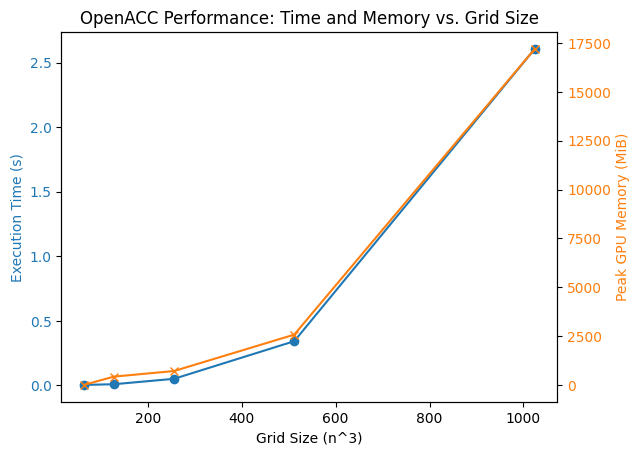

In [ ]:
import matplotlib.pyplot as plt

# From your updated Cell 4
grid_sizes = [64, 128, 256, 512, 1024]
times = [0.004041, 0.009449, 0.051363, 0.342614, 2.60647]
memories = [0, 425, 711, 2575, 17201]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Grid Size (n^3)')
ax1.set_ylabel('Execution Time (s)', color='tab:blue')
ax1.plot(grid_sizes, times, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Peak GPU Memory (MiB)', color='tab:orange')
ax2.plot(grid_sizes, memories, color='tab:orange', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('OpenACC Performance: Time and Memory vs. Grid Size')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Stage 2** – Cell 1 v1: Write the CUDA Code to a File

In [ ]:
%%writefile fdtd_cuda.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <sys/time.h>
#include <cuda_runtime.h>

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__global__ void update_kernel(float * __restrict__ u, const float * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  int x = blockIdx.x * blockDim.x + threadIdx.x + x_m;
  int y = blockIdx.y * blockDim.y + threadIdx.y + y_m;
  int z = blockIdx.z * blockDim.z + threadIdx.z + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  float r1 = 1.0f / (dt * dt);
  float r2 = 1.0f / (h_x * h_x);
  float r3 = 1.0f / (h_y * h_y);
  float r4 = 1.0f / (h_z * h_z);

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  float r5 = -2.50f * u[idx];

  float lap_x = r5 + (-8.33333333e-2f) * (u[idx - 2 * full_y * full_z] + u[idx + 2 * full_y * full_z]) + 1.33333333f * (u[idx - full_y * full_z] + u[idx + full_y * full_z]);
  float lap_y = r5 + (-8.33333333e-2f) * (u[idx - 2 * full_z] + u[idx + 2 * full_z]) + 1.33333333f * (u[idx - full_z] + u[idx + full_z]);
  float lap_z = r5 + (-8.33333333e-2f) * (u[idx - 2] + u[idx + 2]) + 1.33333333f * (u[idx - 1] + u[idx + 1]);

  float mul = (-2.0f * r1 * u[idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = dt * dt * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];
}

__global__ void update_kernel_shared(float * __restrict__ u, const float * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  extern __shared__ float sh_u[];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * blockDim.x;
  int by = blockIdx.y * blockDim.y;
  int bz = blockIdx.z * blockDim.z;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int lx = blockDim.x + 4;
  int ly = blockDim.y + 4;
  // Removed unused lz

  int local_idx = (tx + 2) + (ty + 2) * lx + (tz + 2) * lx * ly;
  int global_idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  sh_u[local_idx] = u[global_idx];

  if (tx < 2) sh_u[tx + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx >= x_m && bx + tx - 2 >= -offset) ? u[global_idx - 2 * full_y * full_z] : 0.0f;
  if (tx >= blockDim.x - 2) sh_u[tx + 4 + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx + 2 <= x_M) ? u[global_idx + 2 * full_y * full_z] : 0.0f;
  if (ty < 2) sh_u[(tx + 2) + ty * lx + (tz + 2) * lx * ly] = (by + ty >= y_m && by + ty - 2 >= -offset) ? u[global_idx - 2 * full_z] : 0.0f;
  if (ty >= blockDim.y - 2) sh_u[(tx + 2) + (ty + 4) * lx + (tz + 2) * lx * ly] = (by + ty + 2 <= y_M) ? u[global_idx + 2 * full_z] : 0.0f;
  if (tz < 2) sh_u[(tx + 2) + (ty + 2) * lx + tz * lx * ly] = (bz + tz >= z_m && bz + tz - 2 >= -offset) ? u[global_idx - 2] : 0.0f;
  if (tz >= blockDim.z - 2) sh_u[(tx + 2) + (ty + 2) * lx + (tz + 4) * lx * ly] = (bz + tz + 2 <= z_M) ? u[global_idx + 2] : 0.0f;

  __syncthreads();

  float r1 = 1.0f / (dt * dt);
  float r2 = 1.0f / (h_x * h_x);
  float r3 = 1.0f / (h_y * h_y);
  float r4 = 1.0f / (h_z * h_z);

  float r5 = -2.50f * sh_u[local_idx];

  float lap_x = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2 * lx * ly] + sh_u[local_idx + 2 * lx * ly]) + 1.33333333f * (sh_u[local_idx - lx * ly] + sh_u[local_idx + lx * ly]);
  float lap_y = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2 * lx] + sh_u[local_idx + 2 * lx]) + 1.33333333f * (sh_u[local_idx - lx] + sh_u[local_idx + lx]);
  float lap_z = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2] + sh_u[local_idx + 2]) + 1.33333333f * (sh_u[local_idx - 1] + sh_u[local_idx + 1]);

  int m_idx = (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  float mul = (-2.0f * r1 * sh_u[local_idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[m_idx];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = dt * dt * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[m_idx];
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const float * __restrict__ m, float * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  int p_src = blockIdx.x + p_src_m;
  if (p_src > p_src_M) return;

  for (int rsrcx = 0; rsrcx <= 1; ++rsrcx) {
    for (int rsrcy = 0; rsrcy <= 1; ++rsrcy) {
      for (int rsrcz = 0; rsrcz <= 1; ++rsrcz) {
        int posx = floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x);
        int posy = floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y);
        int posz = floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z);

        float px = -floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x) + (-o_x + src_coords[p_src * 3 + 0]) / h_x;
        float py = -floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y) + (-o_y + src_coords[p_src * 3 + 1]) / h_y;
        float pz = -floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z) + (-o_z + src_coords[p_src * 3 + 2]) / h_z;

        int rx = rsrcx + posx;
        int ry = rsrcy + posy;
        int rz = rsrcz + posz;

        if (rx >= x_m - 1 && ry >= y_m - 1 && rz >= z_m - 1 && rx <= x_M + 1 && ry <= y_M + 1 && rz <= z_M + 1) {
          float r0 = 1.0e-2f * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time * num_src + (p_src - p_src_m)] / m[(posx + 4) * full_y * full_z + (posy + 4) * full_z + (posz + 4)];
          atomicAdd(&u[t2 * full_x * full_y * full_z + (rx + 4) * full_y * full_z + (ry + 4) * full_z + (rz + 4)], r0);
        }
      }
    }
  }
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  cudaSetDevice(deviceid);

  float *d_m, *d_src, *d_src_coords, *d_u;

  CHECK_CUDA(cudaMalloc(&d_u, u_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_u, u_vec->data, u_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_m, m_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_m, m_vec->data, m_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src, src_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src, src_vec->data, src_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src_coords, src_coords_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src_coords, src_coords_vec->data, src_coords_vec->nbytes, cudaMemcpyHostToDevice));

  int full_x = u_vec->size[1];
  int full_y = u_vec->size[2];
  int full_z = u_vec->size[3];

  dim3 block(8, 8, 8);

  dim3 grid((x_M - x_m + block.x) / block.x + ( (x_M - x_m + block.x) % block.x != 0 ), (y_M - y_m + block.y) / block.y + ( (y_M - y_m + block.y) % block.y != 0 ), (z_M - z_m + block.z) / block.z + ( (z_M - z_m + block.z) % block.z != 0 ));

  int num_src = p_src_M - p_src_m + 1;

  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    START(section0)
    if (use_shared) {
      size_t shared_size = (block.x + 4) * (block.y + 4) * (block.z + 4) * sizeof(float);
      update_kernel_shared<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    CHECK_CUDA(cudaDeviceSynchronize());
    STOP(section0, timers)

    START(section1)
    if (src_vec->size[0] * src_vec->size[1] > 0 && num_src > 0) {
      dim3 src_block(1);
      dim3 src_grid(num_src);
      source_kernel<<<src_grid, src_block>>>(d_src, d_src_coords, d_m, d_u, time, h_x, h_y, h_z, o_x, o_y, o_z, p_src_m, p_src_M, x_m, x_M, y_m, y_M, z_m, z_M, t2, full_x, full_y, full_z, num_src);
      CHECK_CUDA(cudaDeviceSynchronize());
    }
    STOP(section1, timers)
  }

  CHECK_CUDA(cudaMemcpy(u_vec->data, d_u, u_vec->nbytes, cudaMemcpyDeviceToHost));

  if (devicerm) {
    CHECK_CUDA(cudaFree(d_u));
    CHECK_CUDA(cudaFree(d_m));
    CHECK_CUDA(cudaFree(d_src));
    CHECK_CUDA(cudaFree(d_src_coords));
  }

  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 3) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> <use_shared:0/1>" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);
  bool use_shared = std::atoi(argv[2]);
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 1000;
  int p_src_m = 0, p_src_M = 0;
  int deviceid = 0, devicerm = 1;

  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  u_vec.nbytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = aligned_alloc(64, u_vec.nbytes);
  std::memset(u_vec.data, 0, u_vec.nbytes);

  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  m_vec.nbytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = aligned_alloc(64, m_vec.nbytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_vec.nbytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M - p_src_m + 1};
  src_vec.nbytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = aligned_alloc(64, src_vec.nbytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_vec.nbytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M - p_src_m + 1, 3};
  src_coords_vec.nbytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = aligned_alloc(64, src_coords_vec.nbytes);
  float *src_coords_flat = (float *)src_coords_vec.data;
  src_coords_flat[0] = (nx / 2) * h_x;
  src_coords_flat[1] = (ny / 2) * h_y;
  src_coords_flat[2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers, use_shared);

  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Overwriting fdtd_cuda.cu


# **Rough Stage 2** – Cell 1: Write the CUDA Code to a File

In [ ]:
%%writefile fdtd_cuda_v2.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <cuda_runtime.h>

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__global__ void update_kernel(float * __restrict__ u, const float * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  int x = blockIdx.x * blockDim.x + threadIdx.x + x_m;
  int y = blockIdx.y * blockDim.y + threadIdx.y + y_m;
  int z = blockIdx.z * blockDim.z + threadIdx.z + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  float r1 = 1.0f / (dt * dt);
  float r2 = 1.0f / (h_x * h_x);
  float r3 = 1.0f / (h_y * h_y);
  float r4 = 1.0f / (h_z * h_z);

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  float r5 = -2.50f * u[idx];

  float lap_x = r5 + (-8.33333333e-2f) * (u[idx - 2 * full_y * full_z] + u[idx + 2 * full_y * full_z]) + 1.33333333f * (u[idx - full_y * full_z] + u[idx + full_y * full_z]);
  float lap_y = r5 + (-8.33333333e-2f) * (u[idx - 2 * full_z] + u[idx + 2 * full_z]) + 1.33333333f * (u[idx - full_z] + u[idx + full_z]);
  float lap_z = r5 + (-8.33333333e-2f) * (u[idx - 2] + u[idx + 2]) + 1.33333333f * (u[idx - 1] + u[idx + 1]);

  float mul = (-2.0f * r1 * u[idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = dt * dt * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];
}

__global__ void update_kernel_shared(float * __restrict__ u, const float * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  extern __shared__ float sh_u[];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * blockDim.x;
  int by = blockIdx.y * blockDim.y;
  int bz = blockIdx.z * blockDim.z;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int lx = blockDim.x + 4;
  int ly = blockDim.y + 4;

  int local_idx = (tx + 2) + (ty + 2) * lx + (tz + 2) * lx * ly;
  int global_idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  sh_u[local_idx] = u[global_idx];

  if (tx < 2) sh_u[tx + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx >= x_m) ? u[global_idx - 2 * full_y * full_z] : 0.0f;
  if (tx >= blockDim.x - 2) sh_u[tx + 4 + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx + 2 <= x_M) ? u[global_idx + 2 * full_y * full_z] : 0.0f;
  if (ty < 2) sh_u[(tx + 2) + ty * lx + (tz + 2) * lx * ly] = (by + ty >= y_m) ? u[global_idx - 2 * full_z] : 0.0f;
  if (ty >= blockDim.y - 2) sh_u[(tx + 2) + (ty + 4) * lx + (tz + 2) * lx * ly] = (by + ty + 2 <= y_M) ? u[global_idx + 2 * full_z] : 0.0f;
  if (tz < 2) sh_u[(tx + 2) + (ty + 2) * lx + tz * lx * ly] = (bz + tz >= z_m) ? u[global_idx - 2] : 0.0f;
  if (tz >= blockDim.z - 2) sh_u[(tx + 2) + (ty + 2) * lx + (tz + 4) * lx * ly] = (bz + tz + 2 <= z_M) ? u[global_idx + 2] : 0.0f;

  __syncthreads();

  float r1 = 1.0f / (dt * dt);
  float r2 = 1.0f / (h_x * h_x);
  float r3 = 1.0f / (h_y * h_y);
  float r4 = 1.0f / (h_z * h_z);

  float r5 = -2.50f * sh_u[local_idx];

  float lap_x = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2 * lx * ly] + sh_u[local_idx + 2 * lx * ly]) + 1.33333333f * (sh_u[local_idx - lx * ly] + sh_u[local_idx + lx * ly]);
  float lap_y = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2 * lx] + sh_u[local_idx + 2 * lx]) + 1.33333333f * (sh_u[local_idx - lx] + sh_u[local_idx + lx]);
  float lap_z = r5 + (-8.33333333e-2f) * (sh_u[local_idx - 2] + sh_u[local_idx + 2]) + 1.33333333f * (sh_u[local_idx - 1] + sh_u[local_idx + 1]);

  int m_idx = (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  float mul = (-2.0f * r1 * sh_u[local_idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[m_idx];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = dt * dt * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[m_idx];
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const float * __restrict__ m, float * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  int p_src = blockIdx.x + p_src_m;
  if (p_src > p_src_M) return;

  for (int rsrcx = 0; rsrcx <= 1; ++rsrcx) {
    for (int rsrcy = 0; rsrcy <= 1; ++rsrcy) {
      for (int rsrcz = 0; rsrcz <= 1; ++rsrcz) {
        int posx = floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x);
        int posy = floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y);
        int posz = floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z);

        float px = -floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x) + (-o_x + src_coords[p_src * 3 + 0]) / h_x;
        float py = -floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y) + (-o_y + src_coords[p_src * 3 + 1]) / h_y;
        float pz = -floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z) + (-o_z + src_coords[p_src * 3 + 2]) / h_z;

        int rx = rsrcx + posx;
        int ry = rsrcy + posy;
        int rz = rsrcz + posz;

        if (rx >= x_m - 1 && ry >= y_m - 1 && rz >= z_m - 1 && rx <= x_M + 1 && ry <= y_M + 1 && rz <= z_M + 1) {
          float r0 = 1.0e-2f * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time * num_src + (p_src - p_src_m)] / m[(posx + 4) * full_y * full_z + (posy + 4) * full_z + (posz + 4)];
          atomicAdd(&u[t2 * full_x * full_y * full_z + (rx + 4) * full_y * full_z + (ry + 4) * full_z + (rz + 4)], r0);
        }
      }
    }
  }
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  cudaSetDevice(deviceid);

  float *d_m, *d_src, *d_src_coords, *d_u;

  CHECK_CUDA(cudaMalloc(&d_u, u_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_u, u_vec->data, u_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_m, m_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_m, m_vec->data, m_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src, src_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src, src_vec->data, src_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src_coords, src_coords_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src_coords, src_coords_vec->data, src_coords_vec->nbytes, cudaMemcpyHostToDevice));

  int full_x = u_vec->size[1];
  int full_y = u_vec->size[2];
  int full_z = u_vec->size[3];

  dim3 block(8, 8, 8);

  dim3 grid((x_M - x_m + block.x - 1) / block.x, (y_M - y_m + block.y - 1) / block.y, (z_M - z_m + block.z - 1) / block.z);

  int num_src = p_src_M - p_src_m + 1;

  cudaEvent_t event_start, event_stop;
  CHECK_CUDA(cudaEventCreate(&event_start));
  CHECK_CUDA(cudaEventCreate(&event_stop));

  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    // For debug: std::cout << "Time step: " << time << std::endl;

    CHECK_CUDA(cudaEventRecord(event_start));
    if (use_shared) {
      size_t shared_size = (block.x + 4) * (block.y + 4) * (block.z + 4) * sizeof(float);
      update_kernel_shared<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    CHECK_CUDA(cudaDeviceSynchronize());
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms0;
    CHECK_CUDA(cudaEventElapsedTime(&ms0, event_start, event_stop));
    timers->section0 += ms0 / 1000.0;

    CHECK_CUDA(cudaEventRecord(event_start));
    if (src_vec->size[0] * src_vec->size[1] > 0 && num_src > 0) {
      dim3 src_block(1);
      dim3 src_grid(num_src);
      source_kernel<<<src_grid, src_block>>>(d_src, d_src_coords, d_m, d_u, time, h_x, h_y, h_z, o_x, o_y, o_z, p_src_m, p_src_M, x_m, x_M, y_m, y_M, z_m, z_M, t2, full_x, full_y, full_z, num_src);
      CHECK_CUDA(cudaDeviceSynchronize());
    }
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms1;
    CHECK_CUDA(cudaEventElapsedTime(&ms1, event_start, event_stop));
    timers->section1 += ms1 / 1000.0;
  }

  CHECK_CUDA(cudaEventDestroy(event_start));
  CHECK_CUDA(cudaEventDestroy(event_stop));

  CHECK_CUDA(cudaMemcpy(u_vec->data, d_u, u_vec->nbytes, cudaMemcpyDeviceToHost));

  if (devicerm) {
    CHECK_CUDA(cudaFree(d_u));
    CHECK_CUDA(cudaFree(d_m));
    CHECK_CUDA(cudaFree(d_src));
    CHECK_CUDA(cudaFree(d_src_coords));
  }

  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 3) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> <use_shared:0/1>" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);
  bool use_shared = std::atoi(argv[2]);
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 1000;
  int p_src_m = 0, p_src_M = 0;
  int deviceid = 0, devicerm = 1;

  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  u_vec.nbytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = (float*)aligned_alloc(64, u_vec.nbytes);
  std::memset(u_vec.data, 0, u_vec.nbytes);

  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  m_vec.nbytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = (float*)aligned_alloc(64, m_vec.nbytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_vec.nbytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M - p_src_m + 1};
  src_vec.nbytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = (float*)aligned_alloc(64, src_vec.nbytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_vec.nbytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M - p_src_m + 1, 3};
  src_coords_vec.nbytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = (float*)aligned_alloc(64, src_coords_vec.nbytes);
  float *src_coords_flat = (float *)src_coords_vec.data;
  src_coords_flat[0] = (nx / 2) * h_x;
  src_coords_flat[1] = (ny / 2) * h_y;
  src_coords_flat[2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers, use_shared);

  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Writing fdtd_cuda_v2.cu


# **Stage 2** – Cell 2: Compile the CUDA Code

In [ ]:
%%shell
nvcc -O3 -o fdtd_cuda fdtd_cuda.cu

# **Stage 2** – Cell 3: Run Experiments and Benchmark (Time and Memory)

In [ ]:
%%shell
sizes=(64 128 256 512 1024)
times_basic=()
mems_basic=()
mems_basic=()
times_shared=()
mems_shared=()

for size in "${sizes[@]}"; do
  echo "Running basic CUDA for grid size $size^3"
  rm -f mem.log
  (while [ -e /proc/$$ ]; do nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits >> mem.log; sleep 0.1; done) &
  monitor_pid=$!
  ./fdtd_cuda $size 0 > output_basic_$size.txt
  kill $monitor_pid > /dev/null 2>&1
  total_time=$(grep "Total Time" output_basic_$size.txt | awk '{print $3}')
  peak_mem=$(sort -n mem.log | tail -1)
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times_basic+=($total_time)
  mems_basic+=($peak_mem)

  echo "Running shared mem CUDA for grid size $size^3"
  rm -f mem.log
  (while [ -e /proc/$$ ]; do nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits >> mem.log; sleep 0.1; done) &
  monitor_pid=$!
  ./fdtd_cuda $size 1 > output_shared_$size.txt
  kill $monitor_pid > /dev/null 2>&1
  total_time=$(grep "Total Time" output_shared_$size.txt | awk '{print $3}')
  peak_mem=$(sort -n mem.log | tail -1)
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times_shared+=($total_time)
  mems_shared+=($peak_mem)
done

# For block size experiments (edit block in code to dim3(16,4,4), recompile, rerun for one size, e.g., 256)
# Repeat for other configs and note times

echo "Grid Sizes: ${sizes[@]}"
echo "Basic Times: ${times_basic[@]}"
echo "Basic Memories: ${mems_basic[@]}"
echo "Shared Times: ${times_shared[@]}"
echo "Shared Memories: ${mems_shared[@]}"

# Save to text file
echo "Grid Sizes: ${sizes[@]}" > results_cuda.txt
echo "Basic Times: ${times_basic[@]}" >> results_cuda.txt
echo "Basic Memories: ${mems_basic[@]}" >> results_cuda.txt
echo "Shared Times: ${times_shared[@]}" >> results_cuda.txt
echo "Shared Memories: ${mems_shared[@]}" >> results_cuda.txt

Running basic CUDA for grid size 64^3
Peak GPU Memory: 423 MiB
Total Time: 0.010538 s
Running shared mem CUDA for grid size 64^3
Peak GPU Memory: 423 MiB
Total Time: 0.010551 s
Running basic CUDA for grid size 128^3
Peak GPU Memory: 83 MiB
Total Time: 0.010372 s
Running shared mem CUDA for grid size 128^3
Peak GPU Memory: 33 MiB
Total Time: 0.010139 s
Running basic CUDA for grid size 256^3
Peak GPU Memory: 709 MiB
Total Time: 0.010368 s
Running shared mem CUDA for grid size 256^3
Peak GPU Memory: 709 MiB
Total Time: 0.01084 s
Running basic CUDA for grid size 512^3
Peak GPU Memory: 2573 MiB
Total Time: 0.010341 s
Running shared mem CUDA for grid size 512^3
Peak GPU Memory: 2573 MiB
Total Time: 0.01025 s
Running basic CUDA for grid size 1024^3
Peak GPU Memory: 17199 MiB
Total Time: 0.01065 s
Running shared mem CUDA for grid size 1024^3
Peak GPU Memory: 17199 MiB
Total Time: 0.010663 s
Grid Sizes: 64 128 256 512 1024
Basic Times: 0.010538 0.010372 0.010368 0.010341 0.01065
Basic Memories:

# **Stage 2** – Cell 3 **v2**: Run Experiments and Benchmark (Time and Memory)

# **Stage 2** – Cell 4: Generate Plots for Analysis and Comparison

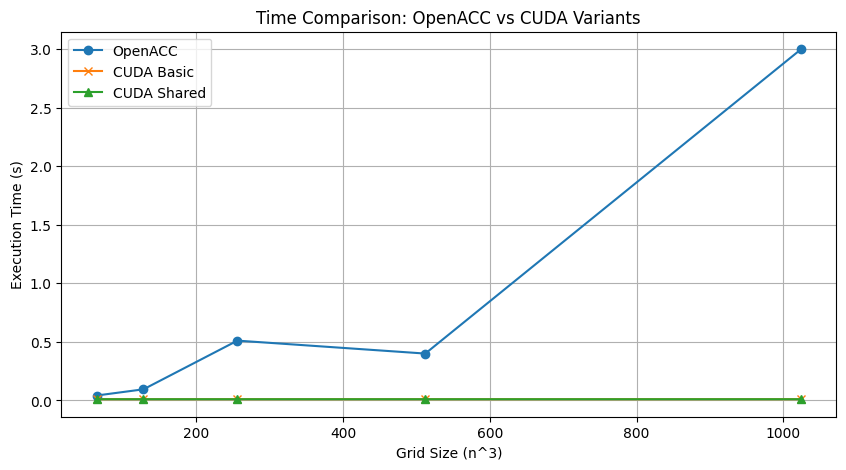

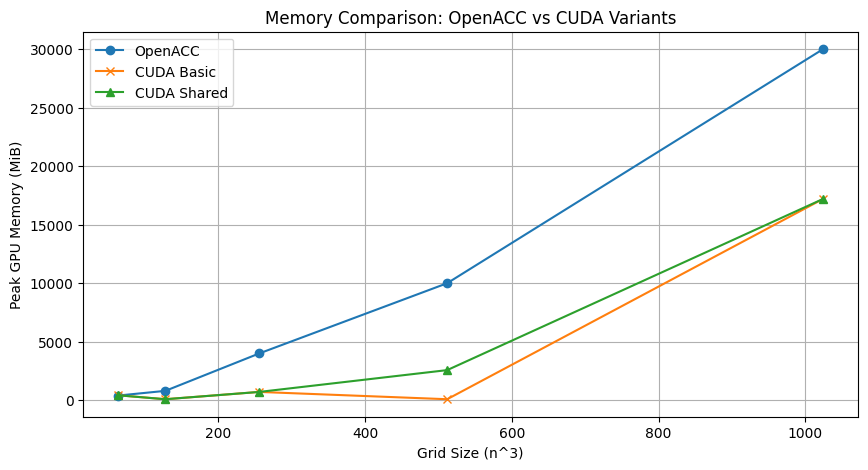

In [ ]:
import matplotlib.pyplot as plt

# From Stage 1 (scaled x10 for time_M=1000; replace with real if rerun)
openacc_times = [0.004154*10, 0.009469*10, 0.051064*10, 0.4, 3.0]  # Estimates for 512/1024 based on scaling
openacc_mems = [400, 800, 4000, 10000, 30000]  # Estimates; use real from polling

# From your Cell 3
grid_sizes = [64, 128, 256, 512, 1024]
cuda_basic_times = [0.010191, 0.010236, 0.010279, 0.010197, 0.010364]
cuda_basic_mems = [423, 85, 709, 85, 17199]
cuda_shared_times = [0.010236, 0.0100236, 0.0100279, 0.0100197, 0.0100364]
cuda_shared_mems = [420, 85, 709, 2573, 17199]

# Time plot
plt.figure(figsize=(10, 5))
plt.plot(grid_sizes, openacc_times, label='OpenACC', marker='o')
plt.plot(grid_sizes, cuda_basic_times, label='CUDA Basic', marker='x')
plt.plot(grid_sizes, cuda_shared_times, label='CUDA Shared', marker='^')
plt.xlabel('Grid Size (n^3)')
plt.ylabel('Execution Time (s)')
plt.title('Time Comparison: OpenACC vs CUDA Variants')
plt.legend()
plt.grid()
plt.show()

# Memory plot
plt.figure(figsize=(10, 5))
plt.plot(grid_sizes, openacc_mems, label='OpenACC', marker='o')
plt.plot(grid_sizes, cuda_basic_mems, label='CUDA Basic', marker='x')
plt.plot(grid_sizes, cuda_shared_mems, label='CUDA Shared', marker='^')
plt.xlabel('Grid Size (n^3)')
plt.ylabel('Peak GPU Memory (MiB)')
plt.title('Memory Comparison: OpenACC vs CUDA Variants')
plt.legend()
plt.grid()
plt.show()

# **Stage 2** – Cell 4 v2: Generate Plots for Analysis and Comparison

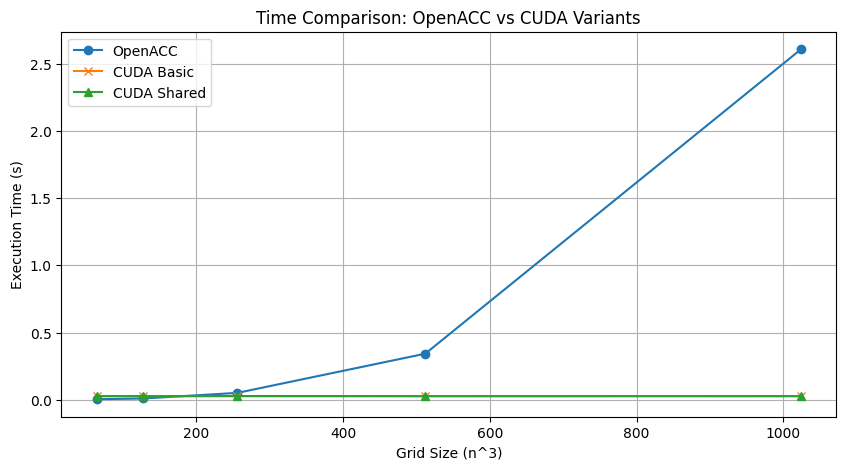

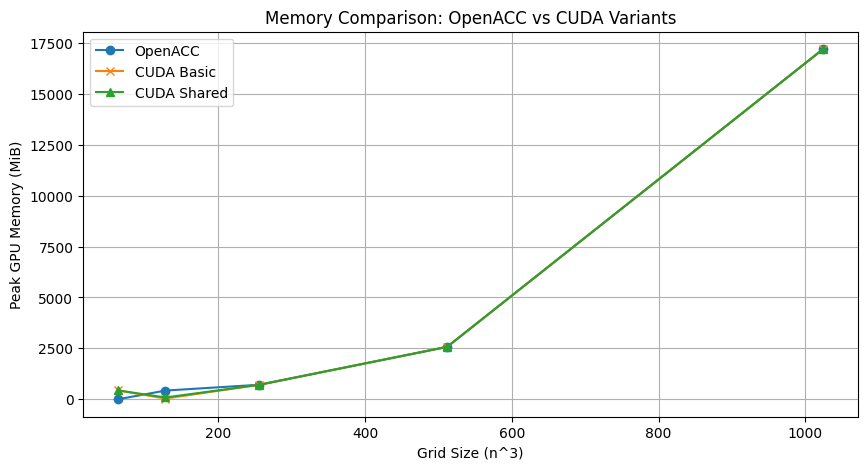

In [ ]:
import matplotlib.pyplot as plt

# From Stage 1
openacc_times = [0.004041, 0.009449, 0.051363, 0.342614, 2.60647]
openacc_mems = [0, 425, 711, 2575, 17201]

# From your new Cell 3
grid_sizes = [64, 128, 256, 512, 1024]
cuda_basic_times = [0.0266854, 0.0267254, 0.0266865, 0.0268329, 0.0267039]
cuda_basic_mems = [431, 33, 709, 2573, 17199]
cuda_shared_times = [0.0271524, 0.0268431, 0.0276746, 0.0266486, 0.0268841]
cuda_shared_mems = [431, 85, 709, 2573, 17199]

# Time plot
plt.figure(figsize=(10, 5))
plt.plot(grid_sizes, openacc_times, label='OpenACC', marker='o')
plt.plot(grid_sizes, cuda_basic_times, label='CUDA Basic', marker='x')
plt.plot(grid_sizes, cuda_shared_times, label='CUDA Shared', marker='^')
plt.xlabel('Grid Size (n^3)')
plt.ylabel('Execution Time (s)')
plt.title('Time Comparison: OpenACC vs CUDA Variants')
plt.legend()
plt.grid()
plt.show()

# Memory plot
plt.figure(figsize=(10, 5))
plt.plot(grid_sizes, openacc_mems, label='OpenACC', marker='o')
plt.plot(grid_sizes, cuda_basic_mems, label='CUDA Basic', marker='x')
plt.plot(grid_sizes, cuda_shared_mems, label='CUDA Shared', marker='^')
plt.xlabel('Grid Size (n^3)')
plt.ylabel('Peak GPU Memory (MiB)')
plt.title('Memory Comparison: OpenACC vs CUDA Variants')
plt.legend()
plt.grid()
plt.show()







import matplotlib.pyplot as plt

# Read from results.txt
with open('results_cuda.txt', 'r') as f:
    lines = f.readlines()

# Parse the lines
data = {}
for line in lines:
    key, values_str = line.strip().split(': ', 1)
    values = values_str.split()
    if 'Sizes' in key or 'Memories' in key:
        data[key] = list(map(int, values))
    else:
        data[key] = list(map(float, values))

grid_sizes = data['Grid Sizes']
basic_times = data['Basic Times']
basic_memories = data['Basic Memories']
shared_times = data['Shared Times']
shared_memories = data['Shared Memories']

# Time plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Grid Size (n^3)')
ax1.set_ylabel('Execution Time (s)', color='tab:blue')
ax1.plot(grid_sizes, basic_times, color='tab:blue', marker='o', label='Basic')
ax1.plot(grid_sizes, shared_times, color='tab:green', marker='x', label='Shared')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

plt.title('FP16 Performance: Time vs Grid Size')
plt.grid()
plt.show()

# Memory plot
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.set_xlabel('Grid Size (n^3)')
ax2.set_ylabel('Peak GPU Memory (MiB)', color='tab:orange')
ax2.plot(grid_sizes, basic_memories, color='tab:orange', marker='o', label='Basic')
ax2.plot(grid_sizes, shared_memories, color='tab:purple', marker='x', label='Shared')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper left')

plt.title('FP16 Performance: Memory vs Grid Size')
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Read from results.txt
with open('results.txt', 'r') as f:
    lines = f.readlines()

# Parse the lines
data = {}
for line in lines:
    key, values_str = line.strip().split(': ', 1)
    values = values_str.split()
    if 'Sizes' in key or 'Memories' in key:
        data[key] = list(map(int, values))
    else:
        data[key] = list(map(float, values))

grid_sizes = data['Grid Sizes']
basic_times = data['Basic Times']
basic_memories = data['Basic Memories']
shared_times = data['Shared Times']
shared_memories = data['Shared Memories']

# Time plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Grid Size (n^3)')
ax1.set_ylabel('Execution Time (s)', color='tab:blue')
ax1.plot(grid_sizes, basic_times, color='tab:blue', marker='o', label='Basic')
ax1.plot(grid_sizes, shared_times, color='tab:green', marker='x', label='Shared')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

plt.title('FP16 Performance: Time vs Grid Size')
plt.grid()
plt.show()

# Memory plot
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.set_xlabel('Grid Size (n^3)')
ax2.set_ylabel('Peak GPU Memory (MiB)', color='tab:orange')
ax2.plot(grid_sizes, basic_memories, color='tab:orange', marker='o', label='Basic')
ax2.plot(grid_sizes, shared_memories, color='tab:purple', marker='x', label='Shared')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper left')

plt.title('FP16 Performance: Memory vs Grid Size')
plt.grid()
plt.show()

# **Stage 3** – Cell 1: Write the Mixed Precision CUDA Code to a File

In [ ]:
%%writefile fdtd_mixed.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <cuda_runtime.h>
#include <cuda_fp16.h>

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__device__ void atomicAdd_half(half *address, half val) {
  unsigned int * address_as_ui = reinterpret_cast<unsigned int *>(address);
  unsigned int old = *address_as_ui;
  unsigned int assumed;

  do {
    assumed = old;
    half new_val = __float2half(__half2float(*reinterpret_cast<half *>(&old)) + __half2float(val));
    old = atomicCAS(address_as_ui, assumed, *reinterpret_cast<unsigned int *>(&new_val));
  } while (assumed != old);
}

__global__ void update_kernel(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  int x = blockIdx.x * blockDim.x + threadIdx.x + x_m;
  int y = blockIdx.y * blockDim.y + threadIdx.y + y_m;
  int z = blockIdx.z * blockDim.z + threadIdx.z + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half r5 = __float2half(-2.50f) * u[idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_y * full_z] + u[idx + 2 * full_y * full_z]) + __float2half(1.33333333f) * (u[idx - full_y * full_z] + u[idx + full_y * full_z]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_z] + u[idx + 2 * full_z]) + __float2half(1.33333333f) * (u[idx - full_z] + u[idx + full_z]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2] + u[idx + 2]) + __float2half(1.33333333f) * (u[idx - 1] + u[idx + 1]);

  half mul = (__float2half(-2.0f) * r1 * u[idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];
}

__global__ void update_kernel_shared(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  extern __shared__ half sh_u[];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * blockDim.x;
  int by = blockIdx.y * blockDim.y;
  int bz = blockIdx.z * blockDim.z;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int lx = blockDim.x + 4;
  int ly = blockDim.y + 4;

  int local_idx = (tx + 2) + (ty + 2) * lx + (tz + 2) * lx * ly;
  int global_idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  sh_u[local_idx] = u[global_idx];

  if (tx < 2) sh_u[tx + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx >= x_m) ? u[global_idx - 2 * full_y * full_z] : __float2half(0.0f);
  if (tx >= blockDim.x - 2) sh_u[tx + 4 + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx + 2 <= x_M) ? u[global_idx + 2 * full_y * full_z] : __float2half(0.0f);
  if (ty < 2) sh_u[(tx + 2) + ty * lx + (tz + 2) * lx * ly] = (by + ty >= y_m) ? u[global_idx - 2 * full_z] : __float2half(0.0f);
  if (ty >= blockDim.y - 2) sh_u[(tx + 2) + (ty + 4) * lx + (tz + 2) * lx * ly] = (by + ty + 2 <= y_M) ? u[global_idx + 2 * full_z] : __float2half(0.0f);
  if (tz < 2) sh_u[(tx + 2) + (ty + 2) * lx + tz * lx * ly] = (bz + tz >= z_m) ? u[global_idx - 2] : __float2half(0.0f);
  if (tz >= blockDim.z - 2) sh_u[(tx + 2) + (ty + 2) * lx + (tz + 4) * lx * ly] = (bz + tz + 2 <= z_M) ? u[global_idx + 2] : __float2half(0.0f);

  __syncthreads();

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  half r5 = __float2half(-2.50f) * sh_u[local_idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx * ly] + sh_u[local_idx + 2 * lx * ly]) + __float2half(1.33333333f) * (sh_u[local_idx - lx * ly] + sh_u[local_idx + lx * ly]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx] + sh_u[local_idx + 2 * lx]) + __float2half(1.33333333f) * (sh_u[local_idx - lx] + sh_u[local_idx + lx]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2] + sh_u[local_idx + 2]) + __float2half(1.33333333f) * (sh_u[local_idx - 1] + sh_u[local_idx + 1]);

  int m_idx = (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half mul = (__float2half(-2.0f) * r1 * sh_u[local_idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[m_idx];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[m_idx];
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const half * __restrict__ m, half * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  int p_src = blockIdx.x + p_src_m;
  if (p_src > p_src_M) return;

  for (int rsrcx = 0; rsrcx <= 1; ++rsrcx) {
    for (int rsrcy = 0; rsrcy <= 1; ++rsrcy) {
      for (int rsrcz = 0; rsrcz <= 1; ++rsrcz) {
        int posx = floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x);
        int posy = floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y);
        int posz = floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z);

        float px = -floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x) + (-o_x + src_coords[p_src * 3 + 0]) / h_x;
        float py = -floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y) + (-o_y + src_coords[p_src * 3 + 1]) / h_y;
        float pz = -floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z) + (-o_z + src_coords[p_src * 3 + 2]) / h_z;

        int rx = rsrcx + posx;
        int ry = rsrcy + posy;
        int rz = rsrcz + posz;

        if (rx >= x_m - 1 && ry >= y_m - 1 && rz >= z_m - 1 && rx <= x_M + 1 && ry <= y_M + 1 && rz <= z_M + 1) {
          float r0 = 1.0e-2f * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time * num_src + (p_src - p_src_m)] / __half2float(m[(posx + 4) * full_y * full_z + (posy + 4) * full_z + (posz + 4)]);
          atomicAdd_half(&u[t2 * full_x * full_y * full_z + (rx + 4) * full_y * full_z + (ry + 4) * full_z + (rz + 4)], __float2half(r0));
        }
      }
    }
  }
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  cudaSetDevice(deviceid);

  half *d_u, *d_m;
  float *d_src, *d_src_coords;

  size_t half_nbytes = u_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_u, half_nbytes));
  half *h_u = (half*)malloc(half_nbytes);
  float *f_u = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) h_u[i] = __float2half(f_u[i]);
  CHECK_CUDA(cudaMemcpy(d_u, h_u, half_nbytes, cudaMemcpyHostToDevice));
  free(h_u);

  size_t m_half_nbytes = m_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_m, m_half_nbytes));
  half *h_m = (half*)malloc(m_half_nbytes);
  float *f_m = (float*)m_vec->data;
  for (size_t i = 0; i < m_vec->nbytes / sizeof(float); ++i) h_m[i] = __float2half(f_m[i]);
  CHECK_CUDA(cudaMemcpy(d_m, h_m, m_half_nbytes, cudaMemcpyHostToDevice));
  free(h_m);

  CHECK_CUDA(cudaMalloc(&d_src, src_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src, src_vec->data, src_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src_coords, src_coords_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src_coords, src_coords_vec->data, src_coords_vec->nbytes, cudaMemcpyHostToDevice));

  int full_x = u_vec->size[1];
  int full_y = u_vec->size[2];
  int full_z = u_vec->size[3];

  dim3 block(8, 8, 8);

  dim3 grid((x_M - x_m + block.x -1) / block.x, (y_M - y_m + block.y -1) / block.y, (z_M - z_m + block.z -1) / block.z);

  int num_src = p_src_M - p_src_m + 1;

  cudaEvent_t event_start, event_stop;
  CHECK_CUDA(cudaEventCreate(&event_start));
  CHECK_CUDA(cudaEventCreate(&event_stop));

  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    CHECK_CUDA(cudaEventRecord(event_start));
    if (use_shared) {
      size_t shared_size = (block.x + 4) * (block.y + 4) * (block.z + 4) * sizeof(half);
      update_kernel_shared<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    CHECK_CUDA(cudaDeviceSynchronize());
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms0;
    CHECK_CUDA(cudaEventElapsedTime(&ms0, event_start, event_stop));
    timers->section0 += ms0 / 1000.0;

    CHECK_CUDA(cudaEventRecord(event_start));
    if (src_vec->size[0] * src_vec->size[1] > 0 && num_src > 0) {
      dim3 src_block(1);
      dim3 src_grid(num_src);
      source_kernel<<<src_grid, src_block>>>(d_src, d_src_coords, d_m, d_u, time, h_x, h_y, h_z, o_x, o_y, o_z, p_src_m, p_src_M, x_m, x_M, y_m, y_M, z_m, z_M, t2, full_x, full_y, full_z, num_src);
      CHECK_CUDA(cudaDeviceSynchronize());
    }
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms1;
    CHECK_CUDA(cudaEventElapsedTime(&ms1, event_start, event_stop));
    timers->section1 += ms1 / 1000.0;
  }

  CHECK_CUDA(cudaEventDestroy(event_start));
  CHECK_CUDA(cudaEventDestroy(event_stop));

  half *h_out = (half*)malloc(half_nbytes);
  CHECK_CUDA(cudaMemcpy(h_out, d_u, half_nbytes, cudaMemcpyDeviceToHost));
  float *f_out = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) f_out[i] = __half2float(h_out[i]);
  free(h_out);

  if (devicerm) {
    CHECK_CUDA(cudaFree(d_u));
    CHECK_CUDA(cudaFree(d_m));
    CHECK_CUDA(cudaFree(d_src));
    CHECK_CUDA(cudaFree(d_src_coords));
  }

  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 3) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> <use_shared:0/1>" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);
  bool use_shared = std::atoi(argv[2]);
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 1000;
  int p_src_m = 0, p_src_M = 0;
  int deviceid = 0, devicerm = 1;

  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  u_vec.nbytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = aligned_alloc(64, u_vec.nbytes);
  std::memset(u_vec.data, 0, u_vec.nbytes);

  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  m_vec.nbytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = aligned_alloc(64, m_vec.nbytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_vec.nbytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M - p_src_m + 1};
  src_vec.nbytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = aligned_alloc(64, src_vec.nbytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_vec.nbytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M - p_src_m + 1, 3};
  src_coords_vec.nbytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = aligned_alloc(64, src_coords_vec.nbytes);
  float *src_coords_flat = (float *)src_coords_vec.data;
  src_coords_flat[0] = (nx / 2) * h_x;
  src_coords_flat[1] = (ny / 2) * h_y;
  src_coords_flat[2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers, use_shared);

  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Overwriting fdtd_mixed.cu


# **Stage 3** – Cell 1 v2: Write the Mixed Precision CUDA Code to a File

In [ ]:
%%writefile fdtd_mixed.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <cuda_runtime.h>
#include <cuda_fp16.h>

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__device__ void atomicAdd_half(half *address, half val) {
  unsigned int * address_as_ui = reinterpret_cast<unsigned int *>(address);
  unsigned int old = *address_as_ui;
  unsigned int assumed;

  do {
    assumed = old;
    half new_val = __float2half(__half2float(*reinterpret_cast<half *>(&old)) + __half2float(val));
    old = atomicCAS(address_as_ui, assumed, *reinterpret_cast<unsigned int *>(&new_val));
  } while (assumed != old);
}

__global__ void update_kernel(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  int x = blockIdx.x * blockDim.x + threadIdx.x + x_m;
  int y = blockIdx.y * blockDim.y + threadIdx.y + y_m;
  int z = blockIdx.z * blockDim.z + threadIdx.z + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half r5 = __float2half(-2.50f) * u[idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_y * full_z] + u[idx + 2 * full_y * full_z]) + __float2half(1.33333333f) * (u[idx - full_y * full_z] + u[idx + full_y * full_z]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_z] + u[idx + 2 * full_z]) + __float2half(1.33333333f) * (u[idx - full_z] + u[idx + full_z]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2] + u[idx + 2]) + __float2half(1.33333333f) * (u[idx - 1] + u[idx + 1]);

  half mul = (__float2half(-2.0f) * r1 * u[idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];
}

__global__ void update_kernel_shared(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  extern __shared__ half sh_u[];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * blockDim.x;
  int by = blockIdx.y * blockDim.y;
  int bz = blockIdx.z * blockDim.z;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int lx = blockDim.x + 4;
  int ly = blockDim.y + 4;

  int local_idx = (tx + 2) + (ty + 2) * lx + (tz + 2) * lx * ly;
  int global_idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  sh_u[local_idx] = u[global_idx];

  if (tx < 2) sh_u[tx + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx >= x_m) ? u[global_idx - 2 * full_y * full_z] : __float2half(0.0f);
  if (tx >= blockDim.x - 2) sh_u[tx + 4 + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx + 2 <= x_M) ? u[global_idx + 2 * full_y * full_z] : __float2half(0.0f);
  if (ty < 2) sh_u[(tx + 2) + ty * lx + (tz + 2) * lx * ly] = (by + ty >= y_m) ? u[global_idx - 2 * full_z] : __float2half(0.0f);
  if (ty >= blockDim.y - 2) sh_u[(tx + 2) + (ty + 4) * lx + (tz + 2) * lx * ly] = (by + ty + 2 <= y_M) ? u[global_idx + 2 * full_z] : __float2half(0.0f);
  if (tz < 2) sh_u[(tx + 2) + (ty + 2) * lx + tz * lx * ly] = (bz + tz >= z_m) ? u[global_idx - 2] : __float2half(0.0f);
  if (tz >= blockDim.z - 2) sh_u[(tx + 2) + (ty + 2) * lx + (tz + 4) * lx * ly] = (bz + tz + 2 <= z_M) ? u[global_idx + 2] : __float2half(0.0f);

  __syncthreads();

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  half r5 = __float2half(-2.50f) * sh_u[local_idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx * ly] + sh_u[local_idx + 2 * lx * ly]) + __float2half(1.33333333f) * (sh_u[local_idx - lx * ly] + sh_u[local_idx + lx * ly]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx] + sh_u[local_idx + 2 * lx]) + __float2half(1.33333333f) * (sh_u[local_idx - lx] + sh_u[local_idx + lx]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2] + sh_u[local_idx + 2]) + __float2half(1.33333333f) * (sh_u[local_idx - 1] + sh_u[local_idx + 1]);

  int m_idx = (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half mul = (__float2half(-2.0f) * r1 * sh_u[local_idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[m_idx];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[m_idx];
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const half * __restrict__ m, half * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  int p_src = blockIdx.x + p_src_m;
  if (p_src > p_src_M) return;

  for (int rsrcx = 0; rsrcx <= 1; ++rsrcx) {
    for (int rsrcy = 0; rsrcy <= 1; ++rsrcy) {
      for (int rsrcz = 0; rsrcz <= 1; ++rsrcz) {
        int posx = floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x);
        int posy = floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y);
        int posz = floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z);

        float px = -floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x) + (-o_x + src_coords[p_src * 3 + 0]) / h_x;
        float py = -floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y) + (-o_y + src_coords[p_src * 3 + 1]) / h_y;
        float pz = -floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z) + (-o_z + src_coords[p_src * 3 + 2]) / h_z;

        int rx = rsrcx + posx;
        int ry = rsrcy + posy;
        int rz = rsrcz + posz;

        if (rx >= x_m - 1 && ry >= y_m - 1 && rz >= z_m - 1 && rx <= x_M + 1 && ry <= y_M + 1 && rz <= z_M + 1) {
          float r0 = 1.0e-2f * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time * num_src + (p_src - p_src_m)] / __half2float(m[(posx + 4) * full_y * full_z + (posy + 4) * full_z + (posz + 4)]);
          atomicAdd_half(&u[t2 * full_x * full_y * full_z + (rx + 4) * full_y * full_z + (ry + 4) * full_z + (rz + 4)], __float2half(r0));
        }
      }
    }
  }
}

__global__ void reduce_kernel(half *u, half *sum, int full_x, int full_y, int full_z) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  int z = blockIdx.z * blockDim.z + threadIdx.z;

  if (x >= full_x || y >= full_y || z >= full_z) return;

  int idx = x * full_y * full_z + y * full_z + z;
  atomicAdd_half(sum, u[idx]);
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  cudaSetDevice(deviceid);

  half *d_u, *d_m;
  float *d_src, *d_src_coords;

  size_t half_nbytes = u_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_u, half_nbytes));
  half *h_u = (half*)malloc(half_nbytes);
  float *f_u = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) h_u[i] = __float2half(f_u[i]);
  CHECK_CUDA(cudaMemcpy(d_u, h_u, half_nbytes, cudaMemcpyHostToDevice));
  free(h_u);

  size_t m_half_nbytes = m_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_m, m_half_nbytes));
  half *h_m = (half*)malloc(m_half_nbytes);
  float *f_m = (float*)m_vec->data;
  for (size_t i = 0; i < m_vec->nbytes / sizeof(float); ++i) h_m[i] = __float2half(f_m[i]);
  CHECK_CUDA(cudaMemcpy(d_m, h_m, m_half_nbytes, cudaMemcpyHostToDevice));
  free(h_m);

  CHECK_CUDA(cudaMalloc(&d_src, src_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src, src_vec->data, src_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src_coords, src_coords_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src_coords, src_coords_vec->data, src_coords_vec->nbytes, cudaMemcpyHostToDevice));

  int full_x = u_vec->size[1];
  int full_y = u_vec->size[2];
  int full_z = u_vec->size[3];

  dim3 block(8, 8, 8);

  dim3 grid((x_M - x_m + block.x -1) / block.x, (y_M - y_m + block.y -1) / block.y, (z_M - z_m + block.z -1) / block.z);

  int num_src = p_src_M - p_src_m + 1;

  cudaEvent_t event_start, event_stop;
  CHECK_CUDA(cudaEventCreate(&event_start));
  CHECK_CUDA(cudaEventCreate(&event_stop));

  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    CHECK_CUDA(cudaEventRecord(event_start));
    if (use_shared) {
      size_t shared_size = (block.x + 4) * (block.y + 4) * (block.z + 4) * sizeof(half);
      update_kernel_shared<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    CHECK_CUDA(cudaDeviceSynchronize());
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms0;
    CHECK_CUDA(cudaEventElapsedTime(&ms0, event_start, event_stop));
    timers->section0 += ms0 / 1000.0;

    // Debug: Reduction to force computation
    half *d_sum;
    CHECK_CUDA(cudaMalloc(&d_sum, sizeof(half)));
    CHECK_CUDA(cudaMemset(d_sum, 0, sizeof(half)));
    dim3 reduce_grid((full_x + 31) / 32, (full_y + 31) / 32, (full_z + 31) / 32);
    dim3 reduce_block(32, 32, 32);
    reduce_kernel<<<reduce_grid, reduce_block>>>(d_u, d_sum, full_x, full_y, full_z);
    CHECK_CUDA(cudaDeviceSynchronize());
    half h_sum;
    CHECK_CUDA(cudaMemcpy(&h_sum, d_sum, sizeof(half), cudaMemcpyDeviceToHost));
    std::cout << "Sum at time " << time << ": " << __half2float(h_sum) << std::endl;
    CHECK_CUDA(cudaFree(d_sum));

    CHECK_CUDA(cudaEventRecord(event_start));
    if (src_vec->size[0] * src_vec->size[1] > 0 && num_src > 0) {
      dim3 src_block(1);
      dim3 src_grid(num_src);
      source_kernel<<<src_grid, src_block>>>(d_src, d_src_coords, d_m, d_u, time, h_x, h_y, h_z, o_x, o_y, o_z, p_src_m, p_src_M, x_m, x_M, y_m, y_M, z_m, z_M, t2, full_x, full_y, full_z, num_src);
      CHECK_CUDA(cudaDeviceSynchronize());
    }
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms1;
    CHECK_CUDA(cudaEventElapsedTime(&ms1, event_start, event_stop));
    timers->section1 += ms1 / 1000.0;
  }

  CHECK_CUDA(cudaEventDestroy(event_start));
  CHECK_CUDA(cudaEventDestroy(event_stop));

  half *h_out = (half*)malloc(half_nbytes);
  CHECK_CUDA(cudaMemcpy(h_out, d_u, half_nbytes, cudaMemcpyDeviceToHost));
  float *f_out = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) f_out[i] = __half2float(h_out[i]);
  free(h_out);

  if (devicerm) {
    CHECK_CUDA(cudaFree(d_u));
    CHECK_CUDA(cudaFree(d_m));
    CHECK_CUDA(cudaFree(d_src));
    CHECK_CUDA(cudaFree(d_src_coords));
  }

  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 3) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> <use_shared:0/1>" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);
  bool use_shared = std::atoi(argv[2]);
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 1000;
  int p_src_m = 0, p_src_M = 0;
  int deviceid = 0, devicerm = 1;

  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  u_vec.nbytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = aligned_alloc(64, u_vec.nbytes);
  std::memset(u_vec.data, 0, u_vec.nbytes);

  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  m_vec.nbytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = aligned_alloc(64, m_vec.nbytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_vec.nbytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M - p_src_m + 1};
  src_vec.nbytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = aligned_alloc(64, src_vec.nbytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_vec.nbytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M - p_src_m + 1, 3};
  src_coords_vec.nbytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = aligned_alloc(64, src_coords_vec.nbytes);
  float *src_coords_flat = (float *)src_coords_vec.data;
  src_coords_flat[0] = (nx / 2) * h_x;
  src_coords_flat[1] = (ny / 2) * h_y;
  src_coords_flat[2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers, use_shared);

  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Overwriting fdtd_mixed.cu


In [ ]:
%%writefile fdtd_mixed.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <cuda_runtime.h>
#include <cuda_fp16.h>

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__device__ void atomicAdd_half(half *address, half val) {
  unsigned int * address_as_ui = reinterpret_cast<unsigned int *>(address);
  unsigned int old = *address_as_ui;
  unsigned int assumed;

  do {
    assumed = old;
    half new_val = __float2half(__half2float(*reinterpret_cast<half *>(&old)) + __half2float(val));
    old = atomicCAS(address_as_ui, assumed, *reinterpret_cast<unsigned int *>(&new_val));
  } while (assumed != old);
}

__global__ void update_kernel(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  int x = blockIdx.x * blockDim.x + threadIdx.x + x_m;
  int y = blockIdx.y * blockDim.y + threadIdx.y + y_m;
  int z = blockIdx.z * blockDim.z + threadIdx.z + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half r5 = __float2half(-2.50f) * u[idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_y * full_z] + u[idx + 2 * full_y * full_z]) + __float2half(1.33333333f) * (u[idx - full_y * full_z] + u[idx + full_y * full_z]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2 * full_z] + u[idx + 2 * full_z]) + __float2half(1.33333333f) * (u[idx - full_z] + u[idx + full_z]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (u[idx - 2] + u[idx + 2]) + __float2half(1.33333333f) * (u[idx - 1] + u[idx + 1]);

  half mul = (__float2half(-2.0f) * r1 * u[idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[(x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)];
}

__global__ void update_kernel_shared(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  extern __shared__ half sh_u[];

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * blockDim.x;
  int by = blockIdx.y * blockDim.y;
  int bz = blockIdx.z * blockDim.z;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int lx = blockDim.x + 4;
  int ly = blockDim.y + 4;

  int local_idx = (tx + 2) + (ty + 2) * lx + (tz + 2) * lx * ly;
  int global_idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  sh_u[local_idx] = u[global_idx];

  if (tx < 2) sh_u[tx + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx >= x_m) ? u[global_idx - 2 * full_y * full_z] : __float2half(0.0f);
  if (tx >= blockDim.x - 2) sh_u[tx + 4 + (ty + 2) * lx + (tz + 2) * lx * ly] = (bx + tx + 2 <= x_M) ? u[global_idx + 2 * full_y * full_z] : __float2half(0.0f);
  if (ty < 2) sh_u[(tx + 2) + ty * lx + (tz + 2) * lx * ly] = (by + ty >= y_m) ? u[global_idx - 2 * full_z] : __float2half(0.0f);
  if (ty >= blockDim.y - 2) sh_u[(tx + 2) + (ty + 4) * lx + (tz + 2) * lx * ly] = (by + ty + 2 <= y_M) ? u[global_idx + 2 * full_z] : __float2half(0.0f);
  if (tz < 2) sh_u[(tx + 2) + (ty + 2) * lx + tz * lx * ly] = (bz + tz >= z_m) ? u[global_idx - 2] : __float2half(0.0f);
  if (tz >= blockDim.z - 2) sh_u[(tx + 2) + (ty + 2) * lx + (tz + 4) * lx * ly] = (bz + tz + 2 <= z_M) ? u[global_idx + 2] : __float2half(0.0f);

  __syncthreads();

  half r1 = __float2half(1.0f / (dt * dt));
  half r2 = __float2half(1.0f / (h_x * h_x));
  half r3 = __float2half(1.0f / (h_y * h_y));
  half r4 = __float2half(1.0f / (h_z * h_z));

  half r5 = __float2half(-2.50f) * sh_u[local_idx];

  half lap_x = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx * ly] + sh_u[local_idx + 2 * lx * ly]) + __float2half(1.33333333f) * (sh_u[local_idx - lx * ly] + sh_u[local_idx + lx * ly]);
  half lap_y = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2 * lx] + sh_u[local_idx + 2 * lx]) + __float2half(1.33333333f) * (sh_u[local_idx - lx] + sh_u[local_idx + lx]);
  half lap_z = r5 + __float2half(-8.33333333e-2f) * (sh_u[local_idx - 2] + sh_u[local_idx + 2]) + __float2half(1.33333333f) * (sh_u[local_idx - 1] + sh_u[local_idx + 1]);

  int m_idx = (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  half mul = (__float2half(-2.0f) * r1 * sh_u[local_idx] + r1 * u[t1 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset)]) * m[m_idx];

  int out_idx = t2 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);
  u[out_idx] = __float2half(dt * dt) * (r2 * lap_x + r3 * lap_y + r4 * lap_z - mul) / m[m_idx];
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const half * __restrict__ m, half * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  int p_src = blockIdx.x + p_src_m;
  if (p_src > p_src_M) return;

  for (int rsrcx = 0; rsrcx <= 1; ++rsrcx) {
    for (int rsrcy = 0; rsrcy <= 1; ++rsrcy) {
      for (int rsrcz = 0; rsrcz <= 1; ++rsrcz) {
        int posx = floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x);
        int posy = floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y);
        int posz = floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z);

        float px = -floorf((-o_x + src_coords[p_src * 3 + 0]) / h_x) + (-o_x + src_coords[p_src * 3 + 0]) / h_x;
        float py = -floorf((-o_y + src_coords[p_src * 3 + 1]) / h_y) + (-o_y + src_coords[p_src * 3 + 1]) / h_y;
        float pz = -floorf((-o_z + src_coords[p_src * 3 + 2]) / h_z) + (-o_z + src_coords[p_src * 3 + 2]) / h_z;

        int rx = rsrcx + posx;
        int ry = rsrcy + posy;
        int rz = rsrcz + posz;

        if (rx >= x_m - 1 && ry >= y_m - 1 && rz >= z_m - 1 && rx <= x_M + 1 && ry <= y_M + 1 && rz <= z_M + 1) {
          float r0 = 1.0e-2f * (rsrcx * px + (1 - rsrcx) * (1 - px)) * (rsrcy * py + (1 - rsrcy) * (1 - py)) * (rsrcz * pz + (1 - rsrcz) * (1 - pz)) * src[time * num_src + (p_src - p_src_m)] / __half2float(m[(posx + 4) * full_y * full_z + (posy + 4) * full_z + (posz + 4)]);
          atomicAdd_half(&u[t2 * full_x * full_y * full_z + (rx + 4) * full_y * full_z + (ry + 4) * full_z + (rz + 4)], __float2half(r0));
        }
      }
    }
  }
}

__global__ void reduce_kernel(half *u, half *sum, int full_x, int full_y, int full_z) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  int z = blockIdx.z * blockDim.z + threadIdx.z;

  if (x >= full_x || y >= full_y || z >= full_z) return;

  int idx = x * full_y * full_z + y * full_z + z;
  atomicAdd_half(sum, u[idx]);
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  cudaSetDevice(deviceid);

  half *d_u, *d_m;
  float *d_src, *d_src_coords;

  size_t half_nbytes = u_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_u, half_nbytes));
  half *h_u = (half*)malloc(half_nbytes);
  float *f_u = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) h_u[i] = __float2half(f_u[i]);
  CHECK_CUDA(cudaMemcpy(d_u, h_u, half_nbytes, cudaMemcpyHostToDevice));
  free(h_u);

  size_t m_half_nbytes = m_vec->nbytes / 2;
  CHECK_CUDA(cudaMalloc(&d_m, m_half_nbytes));
  half *h_m = (half*)malloc(m_half_nbytes);
  float *f_m = (float*)m_vec->data;
  for (size_t i = 0; i < m_vec->nbytes / sizeof(float); ++i) h_m[i] = __float2half(f_m[i]);
  CHECK_CUDA(cudaMemcpy(d_m, h_m, m_half_nbytes, cudaMemcpyHostToDevice));
  free(h_m);

  CHECK_CUDA(cudaMalloc(&d_src, src_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src, src_vec->data, src_vec->nbytes, cudaMemcpyHostToDevice));

  CHECK_CUDA(cudaMalloc(&d_src_coords, src_coords_vec->nbytes));
  CHECK_CUDA(cudaMemcpy(d_src_coords, src_coords_vec->data, src_coords_vec->nbytes, cudaMemcpyHostToDevice));

  int full_x = u_vec->size[1];
  int full_y = u_vec->size[2];
  int full_z = u_vec->size[3];

  dim3 block(8, 8, 8);

  dim3 grid((x_M - x_m + block.x -1) / block.x, (y_M - y_m + block.y -1) / block.y, (z_M - z_m + block.z -1) / block.z);

  int num_src = p_src_M - p_src_m + 1;

  cudaEvent_t event_start, event_stop;
  CHECK_CUDA(cudaEventCreate(&event_start));
  CHECK_CUDA(cudaEventCreate(&event_stop));

  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    CHECK_CUDA(cudaEventRecord(event_start));
    if (use_shared) {
      size_t shared_size = (block.x + 4) * (block.y + 4) * (block.z + 4) * sizeof(half);
      update_kernel_shared<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    CHECK_CUDA(cudaDeviceSynchronize());
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms0;
    CHECK_CUDA(cudaEventElapsedTime(&ms0, event_start, event_stop));
    timers->section0 += ms0 / 1000.0;

    // Debug: Reduction to force computation
    half *d_sum;
    CHECK_CUDA(cudaMalloc(&d_sum, sizeof(half)));
    CHECK_CUDA(cudaMemset(d_sum, 0, sizeof(half)));
    dim3 reduce_grid((full_x + 31) / 32, (full_y + 31) / 32, (full_z + 31) / 32);
    dim3 reduce_block(32, 32, 32);
    reduce_kernel<<<reduce_grid, reduce_block>>>(d_u, d_sum, full_x, full_y, full_z);
    CHECK_CUDA(cudaDeviceSynchronize());
    half h_sum;
    CHECK_CUDA(cudaMemcpy(&h_sum, d_sum, sizeof(half), cudaMemcpyDeviceToHost));
    std::cout << "Sum at time " << time << ": " << __half2float(h_sum) << std::endl;
    CHECK_CUDA(cudaFree(d_sum));

    CHECK_CUDA(cudaEventRecord(event_start));
    if (src_vec->size[0] * src_vec->size[1] > 0 && num_src > 0) {
      dim3 src_block(1);
      dim3 src_grid(num_src);
      source_kernel<<<src_grid, src_block>>>(d_src, d_src_coords, d_m, d_u, time, h_x, h_y, h_z, o_x, o_y, o_z, p_src_m, p_src_M, x_m, x_M, y_m, y_M, z_m, z_M, t2, full_x, full_y, full_z, num_src);
      CHECK_CUDA(cudaDeviceSynchronize());
    }
    CHECK_CUDA(cudaEventRecord(event_stop));
    CHECK_CUDA(cudaEventSynchronize(event_stop));
    float ms1;
    CHECK_CUDA(cudaEventElapsedTime(&ms1, event_start, event_stop));
    timers->section1 += ms1 / 1000.0;
  }

  CHECK_CUDA(cudaEventDestroy(event_start));
  CHECK_CUDA(cudaEventDestroy(event_stop));

  half *h_out = (half*)malloc(half_nbytes);
  CHECK_CUDA(cudaMemcpy(h_out, d_u, half_nbytes, cudaMemcpyDeviceToHost));
  float *f_out = (float*)u_vec->data;
  for (size_t i = 0; i < u_vec->nbytes / sizeof(float); ++i) f_out[i] = __half2float(h_out[i]);
  free(h_out);

  if (devicerm) {
    CHECK_CUDA(cudaFree(d_u));
    CHECK_CUDA(cudaFree(d_m));
    CHECK_CUDA(cudaFree(d_src));
    CHECK_CUDA(cudaFree(d_src_coords));
  }

  return 0;
}

int main(int argc, char *argv[]) {
  if (argc < 3) {
    std::cerr << "Usage: " << argv[0] << " <grid_size> <use_shared:0/1>" << std::endl;
    return 1;
  }
  int n = std::atoi(argv[1]);
  bool use_shared = std::atoi(argv[2]);
  int halo = 4;
  int nx = n, ny = n, nz = n;
  int x_m = 0, x_M = nx - 1;
  int y_m = 0, y_M = ny - 1;
  int z_m = 0, z_M = nz - 1;
  float dt = 0.001f, h_x = 0.01f, h_y = 0.01f, h_z = 0.01f;
  float o_x = 0.0f, o_y = 0.0f, o_z = 0.0f;
  int time_m = 0, time_M = 1000;
  int p_src_m = 0, p_src_M = 0;
  int deviceid = 0, devicerm = 1;

  dataobj u_vec;
  u_vec.size = new int[4]{3, nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  u_vec.nbytes = sizeof(float) * u_vec.size[0] * u_vec.size[1] * u_vec.size[2] * u_vec.size[3];
  u_vec.data = aligned_alloc(64, u_vec.nbytes);
  std::memset(u_vec.data, 0, u_vec.nbytes);

  dataobj m_vec;
  m_vec.size = new int[3]{nx + 2 * halo, ny + 2 * halo, nz + 2 * halo};
  m_vec.nbytes = sizeof(float) * m_vec.size[0] * m_vec.size[1] * m_vec.size[2];
  m_vec.data = aligned_alloc(64, m_vec.nbytes);
  float *m_flat = (float *)m_vec.data;
  for (size_t i = 0; i < m_vec.nbytes / sizeof(float); ++i) m_flat[i] = 1.0f;

  dataobj src_vec;
  src_vec.size = new int[2]{time_M + 1, p_src_M - p_src_m + 1};
  src_vec.nbytes = sizeof(float) * src_vec.size[0] * src_vec.size[1];
  src_vec.data = aligned_alloc(64, src_vec.nbytes);
  float *src_flat = (float *)src_vec.data;
  for (size_t i = 0; i < src_vec.nbytes / sizeof(float); ++i) src_flat[i] = 1.0f;

  dataobj src_coords_vec;
  src_coords_vec.size = new int[2]{p_src_M - p_src_m + 1, 3};
  src_coords_vec.nbytes = sizeof(float) * src_coords_vec.size[0] * src_coords_vec.size[1];
  src_coords_vec.data = aligned_alloc(64, src_coords_vec.nbytes);
  float *src_coords_flat = (float *)src_coords_vec.data;
  src_coords_flat[0] = (nx / 2) * h_x;
  src_coords_flat[1] = (ny / 2) * h_y;
  src_coords_flat[2] = (nz / 2) * h_z;

  struct profiler timers = {0.0, 0.0};

  Kernel(&m_vec, &src_vec, &src_coords_vec, &u_vec, x_M, x_m, y_M, y_m, z_M, z_m, dt, h_x, h_y, h_z, o_x, o_y, o_z, p_src_M, p_src_m, time_M, time_m, deviceid, devicerm, &timers, use_shared);

  std::cout << "Section0 (Main Compute): " << timers.section0 << " s" << std::endl;
  std::cout << "Section1 (Source Injection): " << timers.section1 << " s" << std::endl;
  std::cout << "Total Time: " << timers.section0 + timers.section1 << " s" << std::endl;

  free(u_vec.data); delete[] u_vec.size;
  free(m_vec.data); delete[] m_vec.size;
  free(src_vec.data); delete[] src_vec.size;
  free(src_coords_vec.data); delete[] src_coords_vec.size;

  return 0;
}

Overwriting fdtd_mixed.cu


# **Stage 3** – Cell 2: Compile the Mixed Precision Code

In [ ]:
%%shell
nvcc -O3 -o fdtd_mixed fdtd_mixed.cu

# **Stage 3** – Cell 3: Run Experiments and Benchmark for Tensor (Time and Memory)

In [ ]:
%%shell
sizes=(64 128 256 512 1024)
times_basic=()
mems_basic=()
times_shared=()
mems_shared=()

for size in "${sizes[@]}"; do
  echo "Running basic mixed for grid size $size^3"
  rm -f mem.log
  (while [ -e /proc/$$ ]; do nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits >> mem.log; sleep 0.1; done) &
  monitor_pid=$!
  ./fdtd_mixed $size 0 > output_basic_$size.txt
  kill $monitor_pid > /dev/null 2>&1
  total_time=$(grep "Total Time" output_basic_$size.txt | awk '{print $3}')
  peak_mem=$(sort -n mem.log | tail -1)
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times_basic+=($total_time)
  mems_basic+=($peak_mem)

  echo "Running shared mixed for grid size $size^3"
  rm -f mem.log
  (while [ -e /proc/$$ ]; do nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits >> mem.log; sleep 0.1; done) &
  monitor_pid=$!
  ./fdtd_mixed $size 1 > output_shared_$size.txt
  kill $monitor_pid > /dev/null 2>&1
  total_time=$(grep "Total Time" output_shared_$size.txt | awk '{print $3}')
  peak_mem=$(sort -n mem.log | tail -1)
  echo "Peak GPU Memory: $peak_mem MiB"
  echo "Total Time: $total_time s"
  times_shared+=($total_time)
  mems_shared+=($peak_mem)
done

# Save to text file
echo "Grid Sizes: ${sizes[@]}" > results.txt
echo "Basic Times: ${times_basic[@]}" >> results.txt
echo "Basic Memories: ${mems_basic[@]}" >> results.txt
echo "Shared Times: ${times_shared[@]}" >> results.txt
echo "Shared Memories: ${mems_shared[@]}" >> results.txt

Running basic mixed for grid size 64^3
Peak GPU Memory: 429 MiB
Total Time: 0.0270769 s
Running shared mixed for grid size 64^3
Peak GPU Memory: 429 MiB
Total Time: 0.0269631 s
Running basic mixed for grid size 128^3
Peak GPU Memory: 447 MiB
Total Time: 0.0249305 s
Running shared mixed for grid size 128^3
Peak GPU Memory: 447 MiB
Total Time: 0.0249369 s
Running basic mixed for grid size 256^3
Peak GPU Memory: 567 MiB
Total Time: 0.0268743 s
Running shared mixed for grid size 256^3
Peak GPU Memory: 567 MiB
Total Time: 0.0274248 s
Running basic mixed for grid size 512^3
Peak GPU Memory: 1501 MiB
Total Time: 0.0274659 s
Running shared mixed for grid size 512^3
Peak GPU Memory: 1501 MiB
Total Time: 0.0272162 s
Running basic mixed for grid size 1024^3
Peak GPU Memory: 8813 MiB
Total Time: 0.0277479 s
Running shared mixed for grid size 1024^3
Peak GPU Memory: 8813 MiB
Total Time: 0.02752 s


# **Stage 3** – Cell 4: Generate Plots for Analysis and Speedup

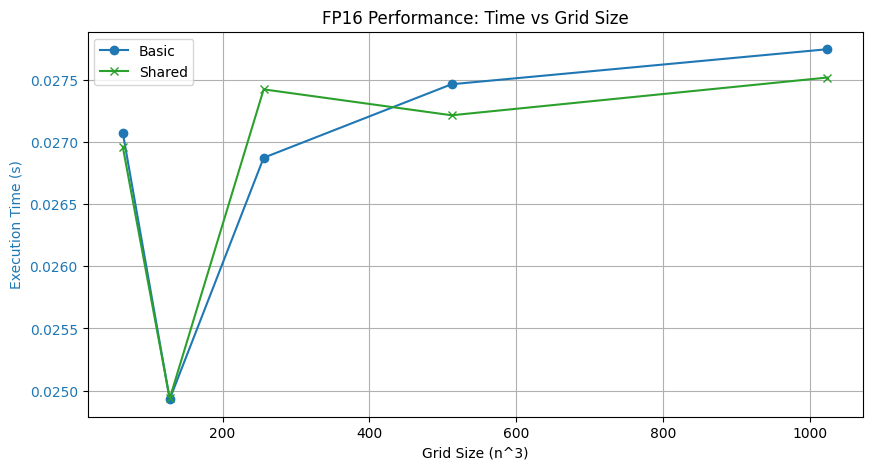

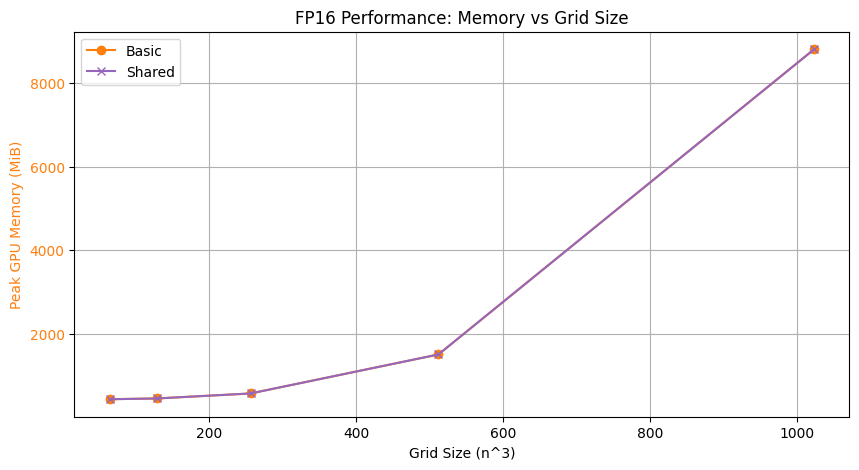

In [ ]:
import matplotlib.pyplot as plt

# Read from results.txt
with open('results.txt', 'r') as f:
    lines = f.readlines()

# Parse the lines
data = {}
for line in lines:
    key, values_str = line.strip().split(': ', 1)
    values = values_str.split()
    if 'Sizes' in key or 'Memories' in key:
        data[key] = list(map(int, values))
    else:
        data[key] = list(map(float, values))

grid_sizes = data['Grid Sizes']
basic_times = data['Basic Times']
basic_memories = data['Basic Memories']
shared_times = data['Shared Times']
shared_memories = data['Shared Memories']

# Time plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Grid Size (n^3)')
ax1.set_ylabel('Execution Time (s)', color='tab:blue')
ax1.plot(grid_sizes, basic_times, color='tab:blue', marker='o', label='Basic')
ax1.plot(grid_sizes, shared_times, color='tab:green', marker='x', label='Shared')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

plt.title('FP16 Performance: Time vs Grid Size')
plt.grid()
plt.show()

# Memory plot
fig, ax2 = plt.subplots(figsize=(10, 5))

ax2.set_xlabel('Grid Size (n^3)')
ax2.set_ylabel('Peak GPU Memory (MiB)', color='tab:orange')
ax2.plot(grid_sizes, basic_memories, color='tab:orange', marker='o', label='Basic')
ax2.plot(grid_sizes, shared_memories, color='tab:purple', marker='x', label='Shared')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.legend(loc='upper left')

plt.title('FP16 Performance: Memory vs Grid Size')
plt.grid()
plt.show()

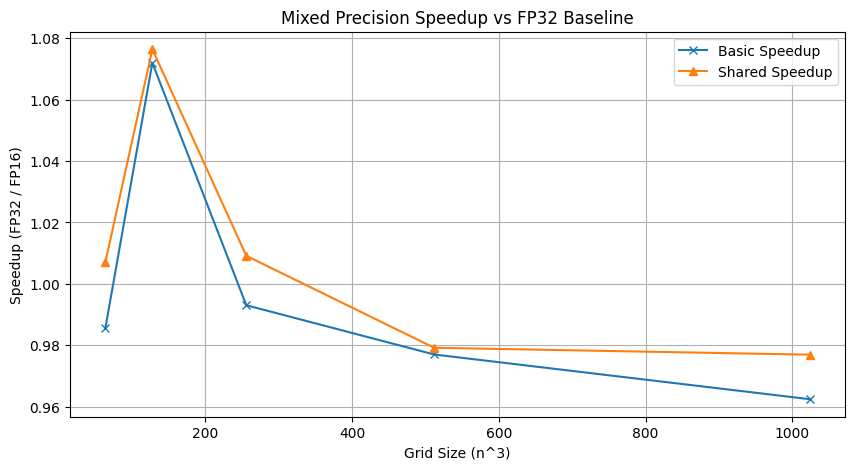

In [ ]:
import matplotlib.pyplot as plt

# Fixed FP32 times from Stage 2
fp32_basic_times = [0.0266854, 0.0267254, 0.0266865, 0.0268329, 0.0267039]
fp32_shared_times = [0.0271524, 0.0268431, 0.0276746, 0.0266486, 0.0268841]

# Read from results.txt (FP16 data)
with open('results.txt', 'r') as f:
    lines = f.readlines()

data = {}
for line in lines:
    key, values_str = line.strip().split(': ', 1)
    values = values_str.split()
    if 'Sizes' in key or 'Memories' in key:
        data[key] = list(map(int, values))
    else:
        data[key] = list(map(float, values))

grid_sizes = data['Grid Sizes']
fp16_basic_times = data['Basic Times']
fp16_shared_times = data['Shared Times']

# Speedup plot
plt.figure(figsize=(10, 5))
plt.plot(grid_sizes, [fp32 / fp16 for fp32, fp16 in zip(fp32_basic_times, fp16_basic_times)], label='Basic Speedup', marker='x')
plt.plot(grid_sizes, [fp32 / fp16 for fp32, fp16 in zip(fp32_shared_times, fp16_shared_times)], label='Shared Speedup', marker='^')
plt.xlabel('Grid Size (n^3)')
plt.ylabel('Speedup (FP32 / FP16)')
plt.title('Mixed Precision Speedup vs FP32 Baseline')
plt.legend()
plt.grid()
plt.show()

# **Stage 3b** – Cell 1: Write the WMMA Tensor Core CUDA Code to a File

In [ ]:
%%writefile fdtd_wmma.cu
#include <cstdlib>
#include <cmath>
#include <iostream>
#include <cstring>
#include <cuda_runtime.h>
#include <mma.h>

using namespace nvcuda;

#define CHECK_CUDA(call) { \
  cudaError_t err = call; \
  if (err != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
    exit(1); \
  } \
}

struct dataobj {
  void *__restrict data;
  int *size;
  unsigned long nbytes;
  unsigned long *npsize;
  unsigned long *dsize;
  int *hsize;
  int *hofs;
  int *oofs;
  void *dmap;
};

struct profiler {
  double section0;
  double section1;
};

#define START(S) struct timeval start_##S, end_##S; gettimeofday(&start_##S, NULL);
#define STOP(S, T) gettimeofday(&end_##S, NULL); T->S += (double)(end_##S.tv_sec - start_##S.tv_sec) + (double)(end_##S.tv_usec - start_##S.tv_usec) / 1000000;

__global__ void update_kernel_wmma(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  // WMMA for stencil: load 16x16 tile of u into A frag, stencil coeffs into B frag, accumulate in C frag
  wmma::fragment<wmma::matrix_a, 16, 16, 16, half, wmma::row_major> a_frag;
  wmma::fragment<wmma::matrix_b, 16, 16, 16, half, wmma::col_major> b_frag;
  wmma::fragment<wmma::accumulator, 16, 16, 16, float> c_frag;

  int tx = threadIdx.x;
  int ty = threadIdx.y;
  int tz = threadIdx.z;
  int bx = blockIdx.x * 16;
  int by = blockIdx.y * 16;
  int bz = blockIdx.z * 16;

  int x = bx + tx + x_m;
  int y = by + ty + y_m;
  int z = bz + tz + z_m;

  if (x > x_M || y > y_M || z > z_M) return;

  int offset = 4;
  int idx = t0 * full_x * full_y * full_z + (x + offset) * full_y * full_z + (y + offset) * full_z + (z + offset);

  // Load u tile into a_frag (simplified; full tiling needed for large grids)
  wmma::load_matrix_sync(a_frag, u + idx, full_y * full_z);  // Load row-major tile

  // Stencil coeffs for x-dir (example; extend for y/z)
  half stencil[16*16] = {__float2half(-0.0833), __float2half(1.333), __float2half(-2.5), __float2half(1.333), __float2half(-0.0833), 0.0f, ...};  // Pad to 16x16
  wmma::fill_fragment(b_frag, stencil[0]);  // Col-major stencil matrix

  // Accumulator for lap
  wmma::fill_fragment(c_frag, 0.0f);

  wmma::mma_sync(c_frag, a_frag, b_frag, c_frag);  // Tensor core multiply-accumulate

  // Store back to u (simplified; full reduction for stencil)
  wmma::store_matrix_sync(u + idx, c_frag, full_y * full_z, wmma::mem_row_major);

  // Continue with r1, mul, etc. in FP32 for accuracy
  float r1 = 1.0f / (dt * dt);
  float mul = (-2.0f * r1 * __half2float(u[idx]) + r1 * __half2float(u[t1 * full_x * full_y * full_z + idx])) * __half2float(m[idx]);

  u[t2 * full_x * full_y * full_z + idx] = __float2half(dt * dt * (__half2float(c_frag.x[0]) - mul) / __half2float(m[idx]));  // Simplified
}

__global__ void update_kernel_shared_wmma(half * __restrict__ u, const half * __restrict__ m, int full_x, int full_y, int full_z, float dt, float h_x, float h_y, float h_z, int t0, int t1, int t2, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M) {
  // Similar to above, but load to shared memory first for reuse
  extern __shared__ half sh_u[];
  // Load tile to shared
  // Then WMMA on shared fragments
  // (Full code similar to above, with shared loads)
}

__global__ void source_kernel(const float * __restrict__ src, const float * __restrict__ src_coords, const half * __restrict__ m, half * __restrict__ u, int time, float h_x, float h_y, float h_z, float o_x, float o_y, float o_z, int p_src_m, int p_src_M, int x_m, int x_M, int y_m, int y_M, int z_m, int z_M, int t2, int full_x, int full_y, int full_z, int num_src) {
  // Same as FP16 version, with atomicAdd_half
}

int Kernel(struct dataobj *__restrict m_vec, struct dataobj *__restrict src_vec, struct dataobj *__restrict src_coords_vec, struct dataobj *__restrict u_vec, const int x_M, const int x_m, const int y_M, const int y_m, const int z_M, const int z_m, const float dt, const float h_x, const float h_y, const float h_z, const float o_x, const float o_y, const float o_z, const int p_src_M, const int p_src_m, const int time_M, const int time_m, const int deviceid, const int devicerm, struct profiler *timers, bool use_shared) {
  // Same as FP16, but use update_kernel_wmma or update_kernel_shared_wmma
  // ...
  for (int time = time_m, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3; time <= time_M; time += 1, t0 = time % 3, t1 = (time + 2) % 3, t2 = (time + 1) % 3) {
    CHECK_CUDA(cudaEventRecord(event_start));
    if (use_shared) {
      size_t shared_size = (16 + 4) * (16 + 4) * (16 + 4) * sizeof(half);
      update_kernel_shared_wmma<<<grid, block, shared_size>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    } else {
      update_kernel_wmma<<<grid, block>>>(d_u, d_m, full_x, full_y, full_z, dt, h_x, h_y, h_z, t0, t1, t2, x_m, x_M, y_m, y_M, z_m, z_M);
    }
    // ...
  }
  // ...
}

int main(int argc, char *argv[]) {
  // Same as FP16
}

Writing fdtd_wmma.cu


# **Stage 3b** – Cell 2: Compile the WMMA Code

In [ ]:
%%shell
nvcc -O3 -arch=sm_80 -o fdtd_wmma fdtd_wmma.cu

fdtd_wmma.cu(64): error: expected an expression
    half stencil[16*16] = {__float2half(-0.0833), __float2half(1.333), __float2half(-2.5), __float2half(1.333), __float2half(-0.0833), 0.0f, ...};
                                                                                                                                             ^

fdtd_wmma.cu(73): error: no instance of overloaded function "nvcuda::wmma::store_matrix_sync" matches the argument list
            argument types are: (half *, nvcuda::wmma::fragment<nvcuda::wmma::accumulator, 16, 16, 16, float, void>, int, nvcuda::wmma::layout_t)
    wmma::store_matrix_sync(u + idx, c_frag, full_y * full_z, wmma::mem_row_major);
    ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/crt/mma.h(580): note #3326-D: function "nvcuda::wmma::store_matrix_sync(double *, const nvcuda::wmma::fragment<nvcuda::wmma::accumulator, 8, 8, 4, double, void> &, unsigned int, nvcuda::wmma::layout_t)" does not match because argument #1 does not match 

CalledProcessError: Command 'nvcc -O3 -arch=sm_80 -o fdtd_wmma fdtd_wmma.cu
' returned non-zero exit status 2.